# Unfixed Polynomal Regression on Linear Data 

This notebook evaluates convergence behavior and generalization performance of SGD on synthetic linear data using polynomial regression models of varying degrees. We compare our three stepsize strategies — fixed, halving, and diminishing — using both training and test error over 20 randomized trials. This setup intentionally overfits by fitting high-degree polynomial models on linear ground truth data to obseve the effects on stepsize computations and overall loss.


In [32]:
import sys
sys.path.append("..") 

import numpy as np
import matplotlib.pyplot as plt
from SGD.sgd import SGD
from data.generate_synthetic_data import generate_training_data_unfixed, generate_training_data_fixed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [33]:
degrees = [1, 2, 3, 4]
n_runs = 20
noise = 0.01
m, n = 100, 2

results_summary = {}

for degree in degrees:
    train_losses = {"fixed": [], "halving": [], "diminishing": []}
    test_losses = {"fixed": [], "halving": [], "diminishing": []}

    for run in range(n_runs):
        X_raw, y, _ = generate_training_data_unfixed(
            m=m, n=n, noise=noise, model_type='linear'
        )

        X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.3)
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_train = poly.fit_transform(X_train_raw)
        X_test = poly.transform(X_test_raw)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        for method in ["fixed", "halving", "diminishing"]:
            sgd = SGD(X_train, y_train, num_iterations=5000, noise=noise)
            w, obj, grad, dist = sgd.optimize(stepsize_type=method)
            train_losses[method].append(obj[-1])

            test_pred = X_test @ w[1:] + w[0]  
            test_loss = np.mean((test_pred - y_test) ** 2)
            test_losses[method].append(test_loss)

    results_summary[degree] = {"train": train_losses, "test": test_losses}

# --- Print summary
for degree in degrees:
    print(f"\nDegree {degree}:")
    for method in ["fixed", "halving", "diminishing"]:
        tr = results_summary[degree]["train"][method]
        te = results_summary[degree]["test"][method]
        print(f"{method.capitalize()} Results:")
        print(f"  Train Loss  - Mean: {np.mean(tr):.4f}, Std: {np.std(tr):.4f}")
        print(f"  Test Loss   - Mean: {np.mean(te):.4f}, Std: {np.std(te):.4f}")


Degree 1:
Fixed Results:
  Train Loss  - Mean: 0.0000, Std: 0.0000
  Test Loss   - Mean: 0.0001, Std: 0.0000
Halving Results:
  Train Loss  - Mean: 0.0000, Std: 0.0000
  Test Loss   - Mean: 0.0001, Std: 0.0000
Diminishing Results:
  Train Loss  - Mean: 0.0024, Std: 0.0041
  Test Loss   - Mean: 0.0044, Std: 0.0077

Degree 2:
Fixed Results:
  Train Loss  - Mean: 0.0108, Std: 0.0143
  Test Loss   - Mean: 0.0258, Std: 0.0281
Halving Results:
  Train Loss  - Mean: 0.0108, Std: 0.0143
  Test Loss   - Mean: 0.0263, Std: 0.0291
Diminishing Results:
  Train Loss  - Mean: 0.0121, Std: 0.0148
  Test Loss   - Mean: 0.0287, Std: 0.0290

Degree 3:
Fixed Results:
  Train Loss  - Mean: 0.5049, Std: 2.1544
  Test Loss   - Mean: 1.0357, Std: 4.4081
Halving Results:
  Train Loss  - Mean: 0.5285, Std: 2.2668
  Test Loss   - Mean: 1.0981, Std: 4.6972
Diminishing Results:
  Train Loss  - Mean: 0.5248, Std: 2.2539
  Test Loss   - Mean: 1.0821, Std: 4.6378

Degree 4:
Fixed Results:
  Train Loss  - Mean: 0.55

### Convergence Plots (Single Run)

We visualize convergence behavior for a single run using a polynomial model with degree 3.

In [34]:
X_raw, y, true_params = generate_training_data_fixed(
    m=100, n=2, noise=0.01, model_type='linear'
)

degree = 3
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X_raw)
scaler = StandardScaler()
X_poly = scaler.fit_transform(X_poly)
results = {}
for method in ["fixed", "halving", "diminishing"]:
    sgd = SGD(X_poly, y, num_iterations=5000, noise=0.01)
    w, obj, grad, dist = sgd.optimize(stepsize_type=method)
    results[method] = {"w": w, "obj": obj, "grad": grad, "dist": dist}


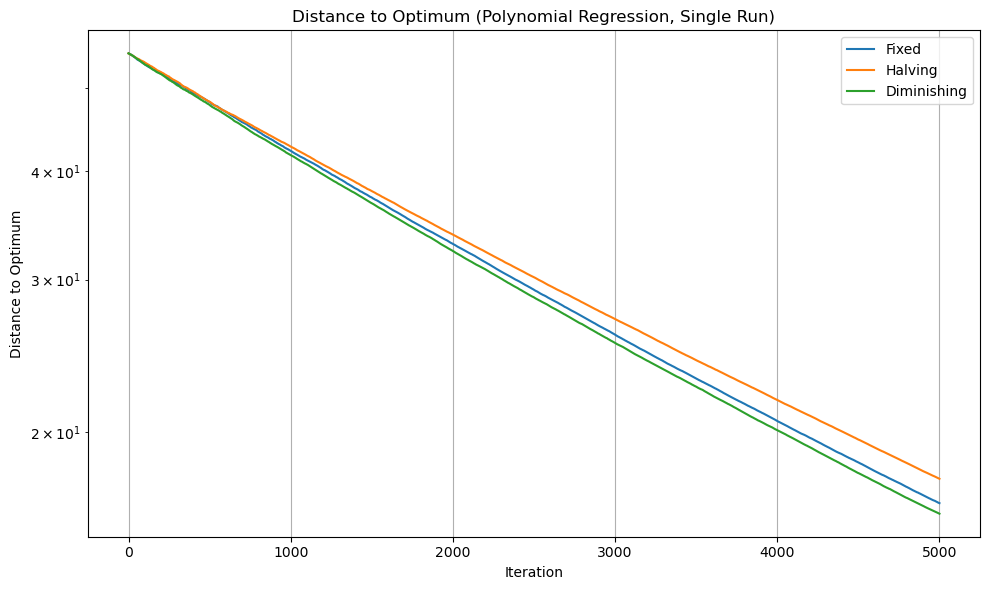

In [35]:

# Plot: Distance to optimum vs. iteration
plt.figure(figsize=(10, 6))
for method in results:
    plt.plot(results[method]["dist"], label=method.capitalize())
plt.xlabel("Iteration")
plt.ylabel("Distance to Optimum")
plt.yscale("log")
plt.title("Distance to Optimum (Polynomial Regression, Single Run)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

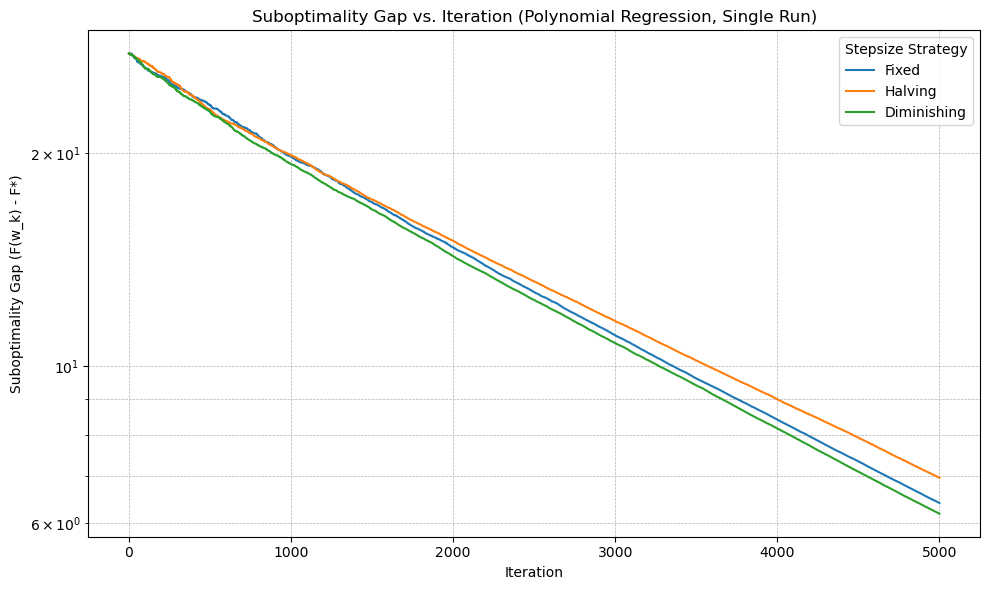

In [36]:
plt.figure(figsize=(10, 6))
plt.yscale("log")

for method in results:
    subopt_gap = results[method]["obj"] - sgd.F_star
    plt.plot(subopt_gap, label=method.capitalize())

plt.xlabel("Iteration")
plt.ylabel("Suboptimality Gap (F(w_k) - F*)")
plt.title("Suboptimality Gap vs. Iteration (Polynomial Regression, Single Run)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(title="Stepsize Strategy")
plt.tight_layout()
plt.show()

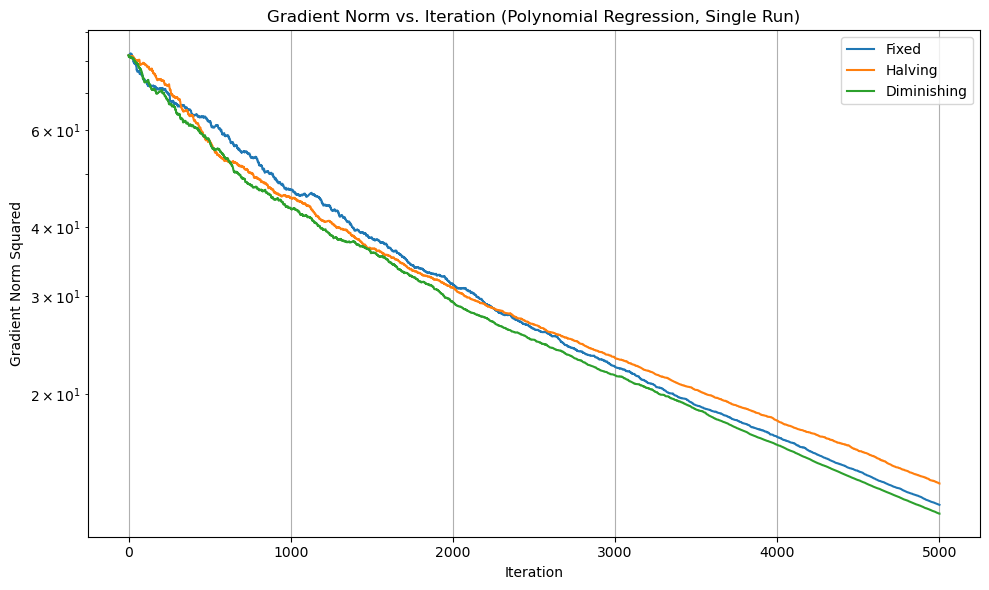

In [37]:
plt.figure(figsize=(10, 6))
for method in results:
    plt.plot(results[method]["grad"], label=method.capitalize())  
plt.xlabel("Iteration")
plt.ylabel("Gradient Norm Squared")
plt.yscale("log")
plt.title("Gradient Norm vs. Iteration (Polynomial Regression, Single Run)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Theoretical Constants
We compute theoretical constants guiding our three stepsize strategies as well as the true and estimated parameters for generated linear data with polynomial regression.

In [38]:
print("SGD Parameters for Fixed Polynomial Run (degree = 3):")
print("="*60)
print(f"L (Lipschitz constant):        {sgd.L:.4f}")
print(f"c (strong convexity):          {sgd.c:.4f}")
print(f"M:                             {sgd.M:.4f}")
print(f"M_V:                           {sgd.M_V:.4f}")
print(f"M_G:                           {sgd.M_G:.4f}")
print(f"mu:                            {sgd.mu:.4f}")
print(f"mu_G:                          {sgd.mu_G:.4f}")
print(f"Fixed stepsize (alphā):        {sgd.fixed_alpha:.6f}")
print(f"Diminishing stepsize (beta):   {sgd.beta:.6f}")
print(f"Diminishing stepsize (gamma):  {sgd.gamma:.6f}")
print("="*60)
print("True Parameters (used to generate synthetic data):")
print(f"A: {true_params['A']}")
print(f"b: {true_params['b']}")

print("\nLearned Parameters from Each Stepsize Strategy:")
print("-" * 60)
for method in results:
    w_method = results[method]["w"]
    print(f"{method.capitalize()} stepsize:")
    print(f"  Bias term (w_0): {w_method[0]:.4f}")
    print(f"  Weights (w_1,...,w_n): {w_method[1:]}")

SGD Parameters for Fixed Polynomial Run (degree = 3):
L (Lipschitz constant):        4.6550
c (strong convexity):          0.0013
M:                             0.0010
M_V:                           1527.0179
M_G:                           1528.0179
mu:                            1.0000
mu_G:                          1.0000
Fixed stepsize (alphā):        0.000141
Diminishing stepsize (beta):   790.755504
Diminishing stepsize (gamma):  5624522.991928
True Parameters (used to generate synthetic data):
A: [1. 2.]
b: 1.0

Learned Parameters from Each Stepsize Strategy:
------------------------------------------------------------
Fixed stepsize:
  Bias term (w_0): 3.4794
  Weights (w_1,...,w_n): [0.22179166 0.49257583 0.17068831 0.37549166 0.43121467 0.12666505
 0.23032089 0.35434519 0.37342794]
Halving stepsize:
  Bias term (w_0): 3.3312
  Weights (w_1,...,w_n): [0.20374151 0.47781909 0.15999308 0.38439396 0.40377387 0.12101751
 0.24776049 0.35495625 0.33724545]
Diminishing stepsize:
  Bi